In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.io import loadmat
from sklearn.metrics import classification_report
np.set_printoptions(linewidth=100)

# DataCollect

In [18]:
path = r"G:\AI学习资料\machine-learning-2014\机器学习课程2014源代码\python代码\ex4-NN back propagation\ex4data1.mat"
raw_data = loadmat(path)
print(f'raw_data["X"].shape: {raw_data["X"].shape}, raw_data["y"].shape:{raw_data["y"].shape}')
#print(raw_data)

raw_data["X"].shape: (5000, 400), raw_data["y"].shape:(5000, 1)


In [19]:
# Define a function 'sigmoid' to compute the sigmoid function.
# 'z' is the input to the sigmoid function.
def sigmoid(z):
    return 1/(1 + np.exp(-z))

# Define a function 'get_xy' to preprocess the raw data.
# 'raw_data' is a dictionary containing the features 'X' and the target 'y'.
# 'trans' is a boolean indicating whether to transpose the feature matrix.
def get_xy(raw_data,trans=True):
    # Extract the feature matrix 'X' from the raw data.
    X = raw_data["X"] # shape: (m x n)
    if trans:
        # Reshape each row of 'X' to a 20x20 matrix, transpose it, and flatten it.
        X = np.array([row.reshape(20,20).T for row in X]) # shape: (m x 20 x 20)
        X = np.array([rm.flatten() for rm in X]) # shape: (m x 400)
    # Insert a column of ones to 'X' as the bias term.
    X = np.insert(X,obj=0,values=1,axis=1) # shape: (m x 401)
    # Extract the target variable 'y' from the raw data.
    y = raw_data["y"] # shape: (m x 1)
    # Replace the label 10 with 0.
    y[y==10]=0
    # Create a matrix 'Y' for the one-hot encoding of 'y'.
    ones = np.ones((10,1)) # shape: (10 x 1)
    Y = ones*y.T # shape: (10 x m)
    i,_ = np.indices((10, y.shape[0])) # shape: (10 x m)
    Y = (Y==i).astype(int) # shape: (10 x m)
    # Flatten 'y' to a one-dimensional array.
    y = raw_data["y"].flatten() # shape: (m,)
    # Replace the label 10 with 0 in 'y'.
    y[y==10]=0                 
    return X, Y, y

# Preprocess the raw data and print the shapes of 'X', 'Y', and 'y'.
X,Y,y = get_xy(raw_data)
print(f'X.shape:{X.shape}, Y.shape:{Y.shape}, y.shape:{y.shape}')

X.shape:(5000, 401), Y.shape:(10, 5000), y.shape:(5000,)


# Display

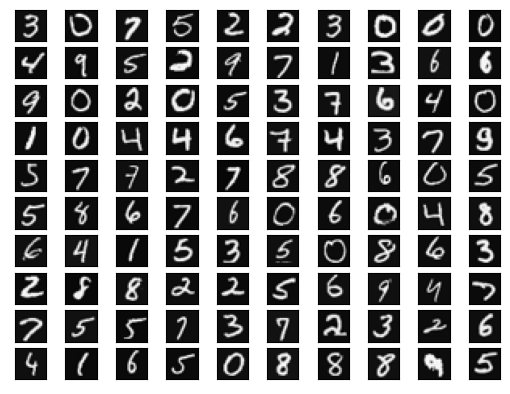

In [20]:
def display(X,r_num=10,c_num=10):
    img_mat = np.delete(X,obj=0,axis=1)
    fig,axes = plt.subplots(nrows=r_num,ncols=c_num,sharex=True, sharey=True)
    rng = np.random.default_rng()
    for row in range(r_num):
        for col in range(c_num):
            #axes[row][col].tick_params(left = False, right = False , labelleft = False ,
             #   labelbottom = False, bottom = False)
            ram_index = rng.integers(0,5000)
            axes[row][col].imshow(X = img_mat[ram_index].reshape(20,20), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
display(X)

# Neural Network

In [21]:
# Define a class 'ThetaHandle' to handle the initialization and reshaping of the parameter matrices 'theta1' and 'theta2'.
class ThetaHandle(object):
    # Initialize the class with the lengths of the three layers 'a1', 'a2', and 'a3'.
    def __init__(self,a1_len, a2_len, a3_len):
        self.a1_len = a1_len
        self.a2_len = a2_len
        self.a3_len = a3_len

    # Define a method 'get_inta' to initialize 'theta1' and 'theta2'.
    def get_inta(self):
        # Compute the epsilon values for initializing 'theta1' and 'theta2'.
        epsilon_1 = np.sqrt(6)/(np.sqrt(self.a1_len+self.a2_len)) # scalar
        epsilon_2 = np.sqrt(6)/(np.sqrt(self.a2_len+self.a3_len)) # scalar
        # Initialize 'theta1' and 'theta2' with random values between -epsilon and epsilon.
        init_theta1 = np.random.rand(self.a2_len,self.a1_len+1)*2*epsilon_1 - epsilon_1 # shape: (a2_len x (a1_len+1))
        init_theta2 = np.random.rand(self.a3_len,self.a2_len+1)*2*epsilon_2 - epsilon_2 # shape: (a3_len x (a2_len+1))
        # Flatten and concatenate 'theta1' and 'theta2'.
        return np.concatenate((init_theta1,init_theta2),axis=None) # shape: ((a2_len*(a1_len+1)) + (a3_len*(a2_len+1)),)

    # Define a method 'get_spta' to reshape the flattened 'theta' back to 'theta1' and 'theta2'.
    def get_spta(self,theta):
        # Reshape the first part of 'theta' to 'theta1'.
        t1 = theta[:self.a2_len*(self.a1_len+1)].reshape(self.a2_len,self.a1_len+1) # shape: (a2_len x (a1_len+1))
        # Reshape the second part of 'theta' to 'theta2'.
        t2 = theta[self.a2_len*(self.a1_len+1):].reshape(self.a3_len,self.a2_len+1) # shape: (a3_len x (a2_len+1))
        return t1, t2

# Create an instance of 'ThetaHandle' with the lengths of the three layers.
theta_hd = ThetaHandle(400,25,10)
# Initialize 'theta'.
init_theta = theta_hd.get_inta() # shape: ((25*(400+1)) + (10*(25+1)),)

In [22]:
# Define a function 'cost' to compute the regularized cost function for a neural network.
# 'theta' is the parameter vector.
# 'X' is the feature matrix (m x n).
# 'Y' is the target variable (m x k).
# 'lamda' is the regularization parameter.
def cost(theta,X,Y,lamda=1):
    # 'm' is the number of training examples.
    m = X.shape[0]
    # 'theta1' and 'theta2' are the parameter matrices for the first and second layer of the neural network, respectively.
    theta1, theta2 = theta_hd.get_spta(theta) # shape: (s x (n+1)) and (k x (s+1))
    # Compute the first part of the cost function.
    part_one = -((Y * np.log(sigmoid(theta2@np.insert(sigmoid(theta1@X.T),obj=0,values=1,axis=0)))).sum(axis=0)).mean()
    # Compute the second part of the cost function.
    part_two = -(((1-Y) * np.log(1 - sigmoid(theta2@np.insert(sigmoid(theta1@X.T),obj=0,values=1,axis=0)))).sum(axis=0)).mean()
    # Compute the regularization term.
    part_regular = (lamda/(2*m))*((np.power(theta1[:,1:],2)).sum() + (np.power(theta2[:,1:],2)).sum())
    # Compute the regularized cost function.
    return part_one + part_two + part_regular

# Compute the cost of the initial parameters 'init_theta'.
cost(init_theta,X,Y)

7.790470994760575

In [23]:
# Define a function 'gradient' to compute the gradient of the regularized cost function for a neural network.
# 'theta' is the parameter vector.
# 'X' is the feature matrix (m x n).
# 'Y' is the target variable (m x k).
# 'lamda' is the regularization parameter.
def gradient(theta,X,Y,lamda=1):
    # 'm' is the number of training examples.
    m = X.shape[0]
    # 'theta1' and 'theta2' are the parameter matrices for the first and second layer of the neural network, respectively.
    theta1, theta2 = theta_hd.get_spta(theta) # shape: (s x (n+1)) and (k x (s+1))
    # Initialize the gradient matrices 'Theta1' and 'Theta2'.
    Theta1 = np.zeros_like(theta1) # shape: (s x (n+1))
    Theta2 = np.zeros_like(theta2) # shape: (k x (s+1))
    # Compute the activations 'a1', 'a2', and 'a3' for the three layers.
    a1 = np.delete(X.T,obj=0,axis=0) # shape: (n x m)
    a2 = sigmoid(theta1@np.insert(a1,obj=0,values=1,axis=0)) # shape: (s x m)
    a3 = sigmoid(theta2@np.insert(a2,obj=0,values=1,axis=0)) # shape: (k x m)
    # Compute the error terms 'deta3' and 'deta2' for the output layer and the hidden layer, respectively.
    deta3 = a3 - Y # shape: (k x m)
    deta2 = np.delete(theta2.T@deta3,obj=0,axis=0)*a2*(1-a2) # shape: (s x m)
    # Compute the gradients 'Theta1' and 'Theta2' using backpropagation.
    for i in range(X.shape[0]):
        Theta1+=deta2[:,i][:,np.newaxis]@np.insert(a1[:,i][np.newaxis,:],obj=0,values=1,axis=1) # shape: (s x (n+1))
        Theta2+=deta3[:,i][:,np.newaxis]@np.insert(a2[:,i][np.newaxis,:],obj=0,values=1,axis=1) # shape: (k x (s+1))
    # Average the gradients over the number of training examples.
    Theta1, Theta2 = (1/m)*Theta1, (1/m)*Theta2 # shape: (s x (n+1)) and (k x (s+1))
    # Compute the regularization term for the gradients.
    Theta1_0, Theta2_0 = Theta1[:,[0]], Theta2[:,[0]] # shape: (s x 1) and (k x 1)
    Theta1 += (lamda/m)*theta1 # shape: (s x (n+1))
    Theta2 += (lamda/m)*theta2 # shape: (k x (s+1))
    # Exclude the bias term from the regularization.
    Theta1[:,[0]], Theta2[:,[0]] = Theta1_0, Theta2_0 # shape: (s x (n+1)) and (k x (s+1))
    # Flatten and concatenate 'Theta1' and 'Theta2'.
    return np.concatenate((Theta1, Theta2),axis=None) # shape: ((s*(n+1)) + (k*(s+1)),)

# Compute the gradient of the initial parameters 'init_theta'.
gradient(init_theta,X,Y)

array([ 1.07216183e-01, -4.41526872e-06, -1.91389392e-05, ...,  1.27382818e-01,  1.50786563e-01,
        1.31048809e-01])

In [24]:
res = optimize.minimize(cost,x0=init_theta,args=(X,Y),method='TNC',jac=gradient,options={"maxfun": 400})
final_theta = res.x


In [25]:
print(res)

     fun: 0.31374559876416225
     jac: array([ 2.27607400e-04, -4.75750473e-08, -2.07984033e-07, ...,  3.77760242e-05, -2.59505075e-06,
        1.01494246e-04])
 message: 'Max. number of function evaluations reached'
    nfev: 401
     nit: 24
  status: 3
 success: False
       x: array([-4.64921321e-02, -2.37875237e-04, -1.03992017e-03, ...,  7.41411880e-01, -2.68166874e+00,
        6.06841912e-01])


In [26]:
def y_predict(final_theta,X):
    final_theta1,final_theta2 = theta_hd.get_spta(final_theta) 
    result_mat = sigmoid(final_theta2@np.insert(sigmoid(final_theta1@X.T),obj=0,values=1,axis=0))
    result = np.argmax(result_mat,axis=0) 
    return result
y_pre = y_predict(final_theta,X)
y_true = y
cla_res = classification_report(y_true,y_pre,zero_division=0)

In [27]:
print(cla_res)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       0.99      1.00      0.99       500
           2       1.00      0.99      0.99       500
           3       1.00      0.99      0.99       500
           4       1.00      1.00      1.00       500
           5       1.00      1.00      1.00       500
           6       1.00      1.00      1.00       500
           7       1.00      1.00      1.00       500
           8       1.00      1.00      1.00       500
           9       0.99      0.99      0.99       500

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



# Check Gradient

In [845]:
from math import pow
from functools import partial
mydata={}
new_theta = theta_hd.get_inta()
new_x = np.random.randint(1,100,(100,60))
new_y = np.random.randint(1,10,(100,1))
mydata["X"] = new_x
mydata["y"] = new_y
X,Y,y = get_xy(mydata,trans=False)
def checkgradient(theta,x,y):
    len = theta.shape[0]
    left_theta = np.repeat(theta[None,:],repeats=len,axis=0)
    right_theta = np.repeat(theta[None,:],repeats=len,axis=0)
    eps_plus = np.eye(len)*pow(10,-4)
    eps_mius = -np.eye(len)*pow(10,-4)
    left_theta += eps_plus
    right_theta += eps_mius
    res1 = gradient(theta,x,y)
    costs = partial(cost,X=x,Y=y)
    lis = [(costs(l)-costs(r))/(2*pow(10,-4)) for l,r in zip(left_theta,right_theta)]
    res2 = np.array(lis)
    return res1, res2